## Predicción de Calidad del Vino (Core)

### Objetivo

Utilizar técnicas de clasificación aprendidas hasta el momento para **predecir la calidad del vino basándose en características físico-químicas**. Este ejercicio permitirá aplicar conceptos como la selección de características, preprocesamiento de datos, entrenamiento y evaluación de modelos de clasificación, y análisis de resultados mediante métricas y visualizaciones.

#### Dataset: Wine Quality Dataset

**Descripción del Dataset**:

Este conjunto de datos contiene información sobre distintas características físico-químicas de muestras de vino tinto y su calidad asociada.

**Las características** incluyen acidez fija, acidez volátil, ácido cítrico, azúcar residual, cloruros, dióxido de azufre libre, dióxido de azufre total, densidad, pH, sulfatos y alcohol. 

La calidad del vino está clasificada en una escala del 0 al 10.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb

### Instrucciones:

 1. Carga y Exploración de Datos:

- Cargar el dataset y revisar su estructura básica.
- Describir las variables y su distribución.
- Identificar y tratar valores nulos y outliers.


In [3]:
#cargar el dataset y revisar su estructura
df = pd.read_csv("../data/WineQT.csv")
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


El dataset está compuesto principalmente por variables continuas que describen diversas propiedades químicas del vino.

La calidad del vino es una variable ordinal que se utiliza en la clasificación y evaluación.

In [4]:
#eliminamos la columna Id por ser irrelevante para predecir la calidad del vino
df.drop('Id', axis=1, inplace=True)
print('Sin la columna Id ',df.shape)

#buscamos y eliminamos duplicados si hubiese
# Identificación de valores duplicados
duplicados = df.duplicated().sum()
print(f'Número de registros duplicados: {duplicados}')

# Eliminación de valores duplicados
df_train = df.drop_duplicates()

Sin la columna Id  (1143, 12)
Número de registros duplicados: 125


Elimino la columna por ser irrelevante para este estudio.

Eliminamos los registros duplicados para favorecer una buena prediccion.

In [5]:
#Calculamos los valores nulos 
#Codigo Hecho por el profesor Iair Linker
def calculate_na_statistics(df: pd.DataFrame):
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = np.round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na = pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %', ascending=False)

null_values = calculate_na_statistics(df)
null_values

,datos sin NAs en q,Na en q,Na en %
fixed acidity,1143,0,0.0
volatile acidity,1143,0,0.0
citric acid,1143,0,0.0
residual sugar,1143,0,0.0
chlorides,1143,0,0.0
free sulfur dioxide,1143,0,0.0
total sulfur dioxide,1143,0,0.0
density,1143,0,0.0
pH,1143,0,0.0
sulphates,1143,0,0.0


No encontramo valore nulos como ya vimos en df.info.

In [6]:
#Codigo para detectar outliers usando el IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [7]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns

# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
fixed acidity,44.0,3.849519,4.6000,12.000
volatile acidity,14.0,1.224847,0.1200,1.005
citric acid,1.0,0.087489,0.0000,0.790
residual sugar,110.0,9.623797,0.9000,3.650
chlorides,77.0,6.736658,0.0410,0.119
free sulfur dioxide,18.0,1.574803,1.0000,42.000
total sulfur dioxide,40.0,3.499563,6.0000,121.000
density,36.0,3.149606,0.9922,1.001
pH,20.0,1.749781,2.9200,3.690
sulphates,43.0,3.762030,0.3300,0.990


### Aca podemos ver que hay un bajo porcentaje de outliers como nos dice en la pagina de kaggle. [The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


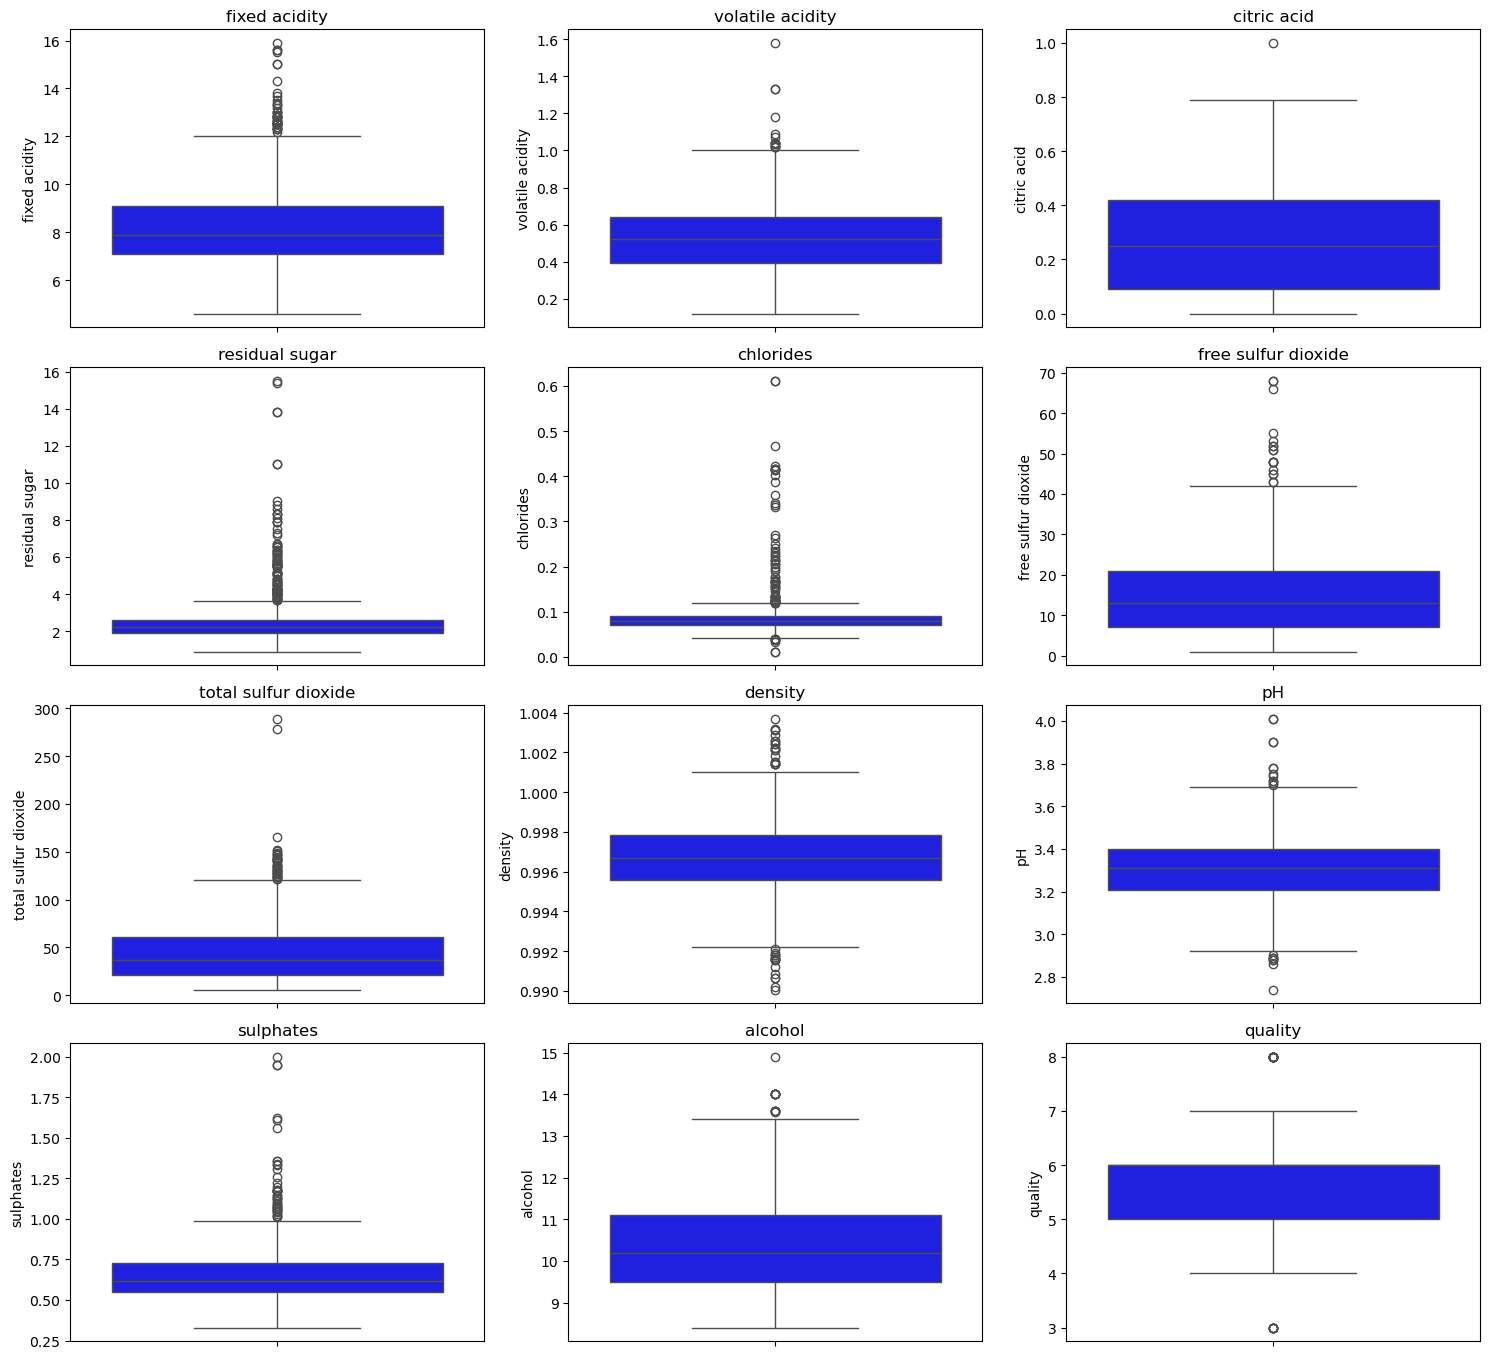

In [9]:
# Configurar el tamaño de la figura 
plt.figure(figsize=(15, 17)) 
# Crear un boxplot para cada variable en el DataFrame 
for i, column in enumerate(df.columns, 1): 
    plt.subplot(len(df.columns)//3 + 1, 3, i) 
    sns.boxplot(data=df[column], orient="v", color="blue") 
    plt.title(column) 
# Ajustar el layout para que los plots no se sobrepongan 
plt.tight_layout() 
# Mostrar los plots 
plt.show()

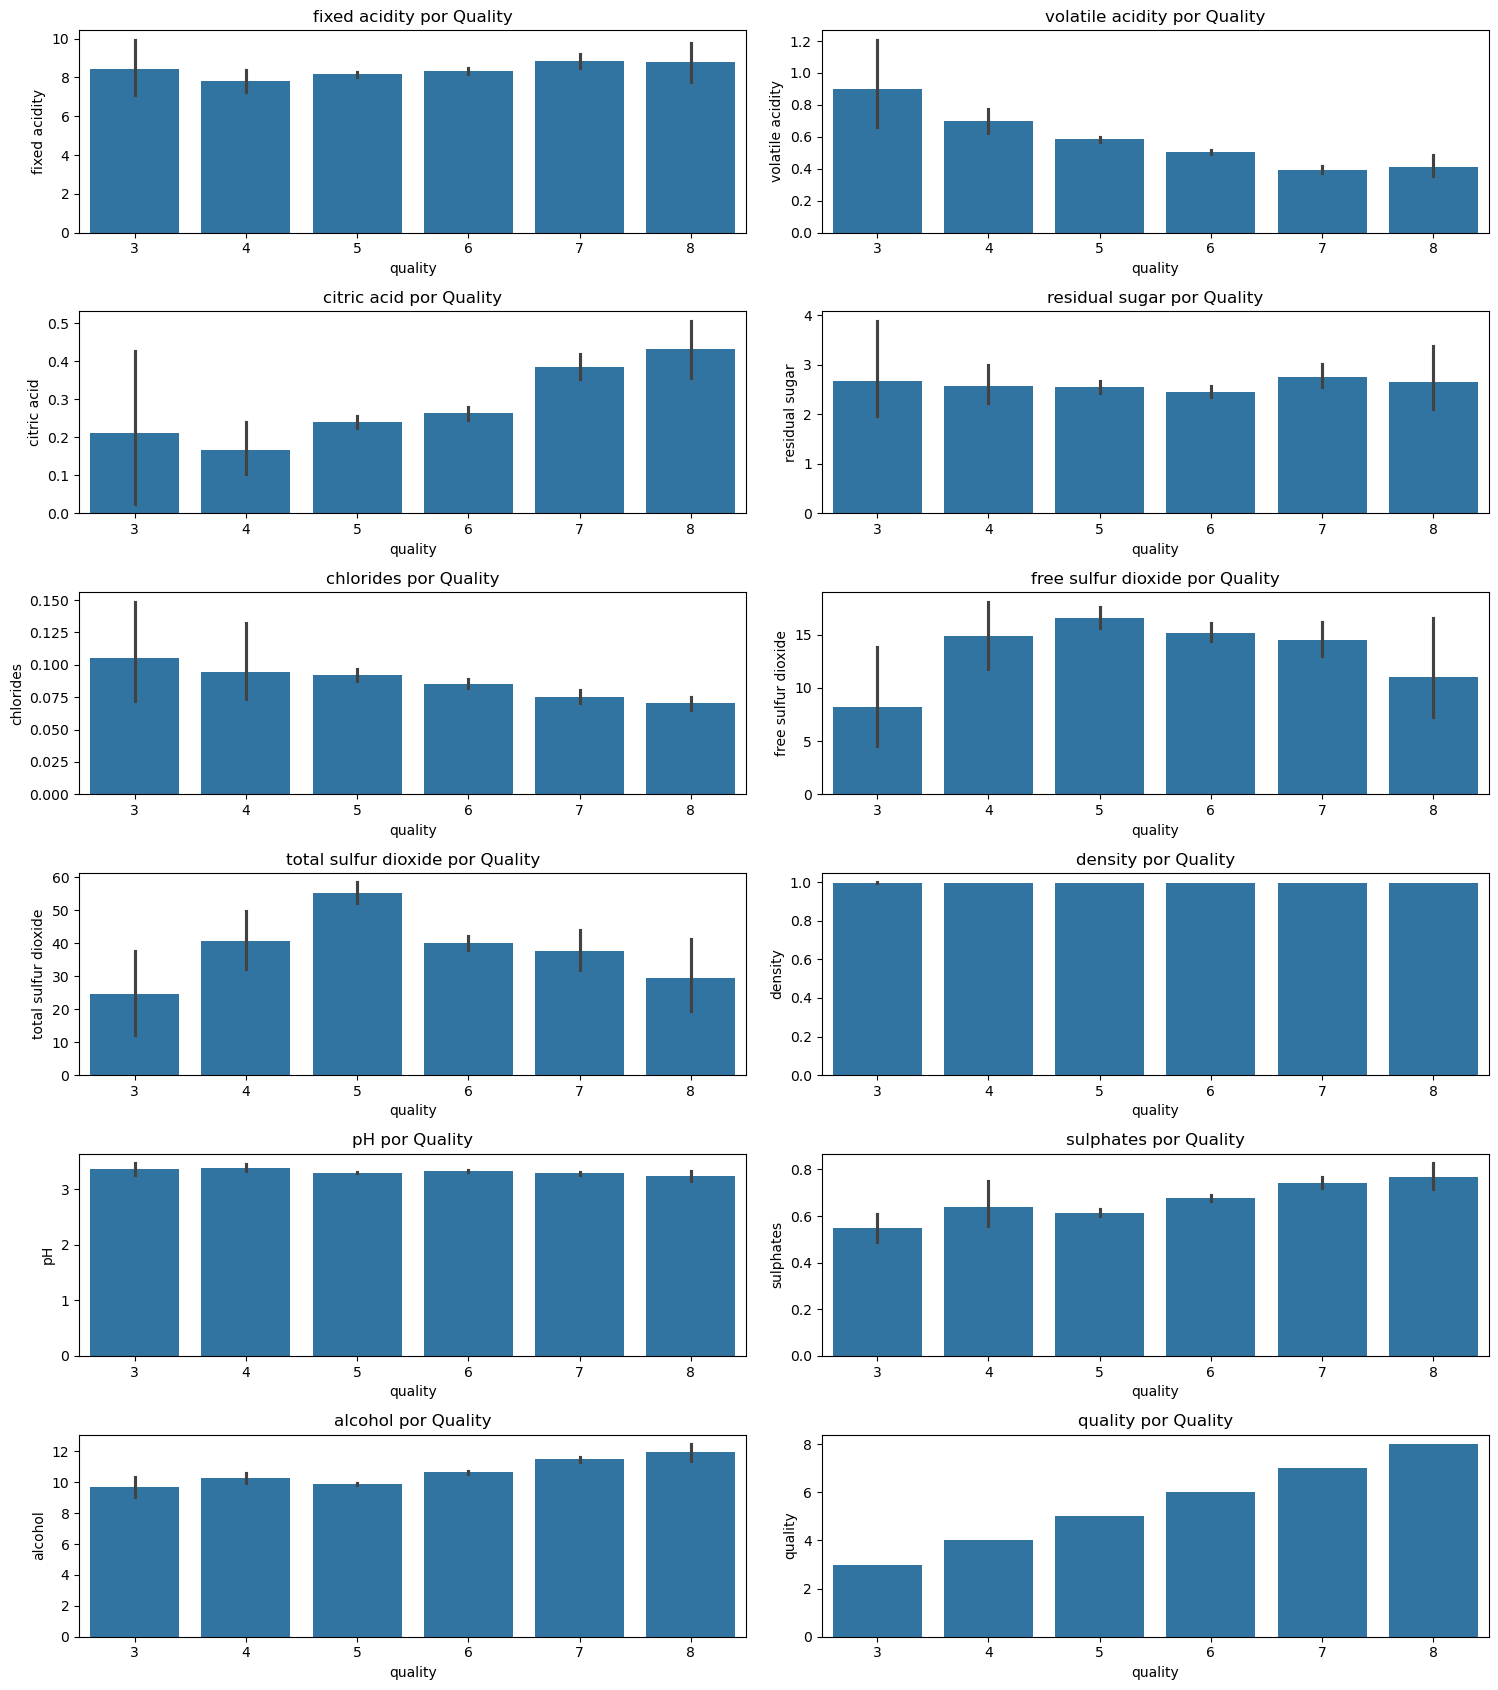

In [10]:
# Configurar el tamaño de la figura
fig, axes = plt.subplots(nrows=len(df.columns)//2, ncols=2, figsize=(15, 17))

# Aplanar los ejes para iterar fácilmente sobre ellos
axes = axes.flatten()

# Crear gráficos de barra para cada variable
for i, column in enumerate(df.columns):
    sns.barplot(x='quality', y=column, data=df, ax=axes[i])
    axes[i].set_title(f'{column} por Quality')

# Ajustar el layout para que los plots no se sobrepongan
plt.tight_layout()

# Mostrar los plots
plt.show()


### Aca podemos visualizar como se distribuyen las variables por nuestro target *Quality*

In [11]:
df['quality'].value_counts()

quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

In [12]:
# agrupar por calidad del vino
qual_group = df.groupby(['quality'])
qual_group.describe().T

quality                      3          4           5           6           7  \
fixed acidity count   6.000000  33.000000  483.000000  462.000000  143.000000   
              mean    8.450000   7.809091    8.161077    8.317749    8.851049   
              std     2.032486   1.685668    1.557746    1.771585    2.105187   
              min     6.700000   4.600000    5.000000    5.000000    4.900000   
              25%     7.150000   6.700000    7.100000    7.000000    7.400000   
...                        ...        ...         ...         ...         ...   
alcohol       min     8.400000   9.000000    8.500000    8.400000    9.200000   
              25%     9.175000   9.400000    9.400000    9.800000   10.800000   
              50%     9.825000  10.000000    9.700000   10.500000   11.600000   
              75%    10.137500  11.000000   10.200000   11.400000   12.100000   
              max    10.900000  13.100000   14.900000   14.000000   14.000000   

quality                      8  
fixed acidity count  16.000000  
              mean    8.806250  
              std     2.089168  
              min     5.000000  
              25%     7.350000  
...                        ...  
alcohol       min     9.800000  
              25%    11.225000  
              50%    11.750000  
              75%    12.825000  
              max    14.000000  

[88 rows x 6 columns]

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

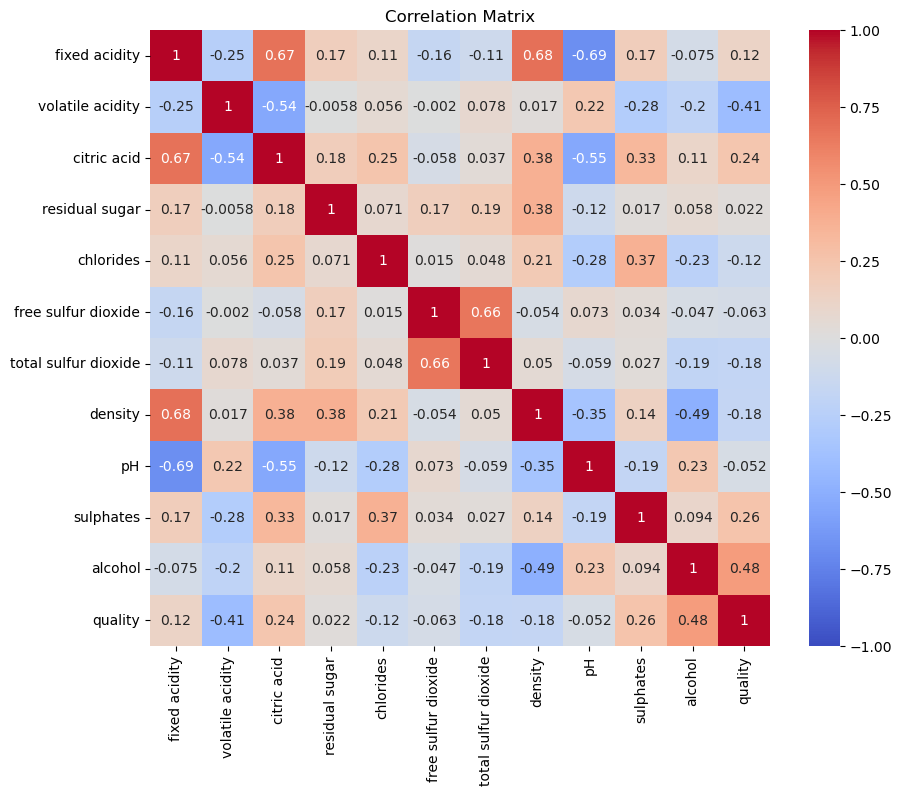

In [13]:
# Correlation for numeric features
print(df[numerical_columns].describe())

# calculate correlation with numerical_features
corr_matrix = df[numerical_columns].corr(method='pearson')

# create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

### Aca no encontramos correlaciones muy fuertes con nuestro Target *Quality*


 2. Preprocesamiento de Datos:

The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones)
- Seleccionar características importantes para la clasificación.
- Transformar variables categóricas en variables numéricas si es necesario.
- Dividir los datos en conjuntos de entrenamiento y prueba.
- Escalar las características.


In [14]:
# definimos el target y las features
y = df['quality']
X = df.drop('quality', axis=1)

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 3. Entrenamiento de Modelos de Clasificación:

- Entrenar al menos tres modelos de clasificación diferentes (por ejemplo, KNN, RandomForest, y Regresión Logística).
- Utilizar validación cruzada para seleccionar los mejores hiperparámetros.


Mejor valor de K: 1


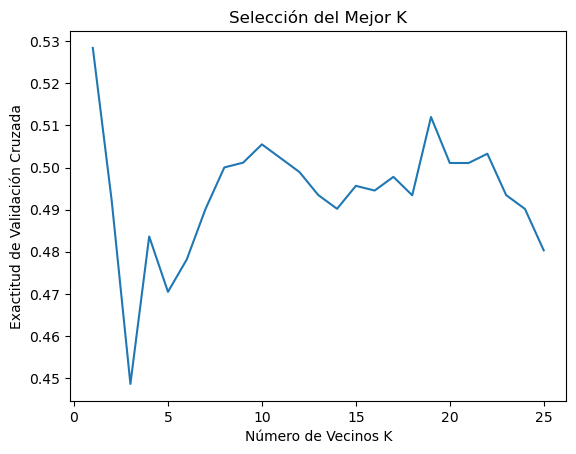

n_estimators = 10: Validation Accuracy = 0.5984
n_estimators = 20: Validation Accuracy = 0.6115
n_estimators = 30: Validation Accuracy = 0.6400
n_estimators = 40: Validation Accuracy = 0.6312
n_estimators = 50: Validation Accuracy = 0.6454

Mejor n_estimators: 50


In [40]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score


# Probar diferentes valores de K
k_values = range(1, 26)
cv_scores_k = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_k.append(scores.mean())

# Seleccionar el K con la mayor exactitud
optimal_k = k_values[cv_scores_k.index(max(cv_scores_k))]
print(f'Mejor valor de K: {optimal_k}')

# Gráfico de la exactitud en función de K
plt.plot(k_values, cv_scores_k)
plt.xlabel('Número de Vecinos K')
plt.ylabel('Exactitud de Validación Cruzada')
plt.title('Selección del Mejor K')
plt.show()

# Entrenar el modelo KNN con el mejor K
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

# Realizar predicciones
y_pred_k = knn.predict(X_test)

# Calcular las probabilidades de predicción
y_prob_k = knn.predict_proba(X_test)


# Definir los valores de n_estimators a probar
n_estimators_range = [10, 20, 30, 40, 50]

# Almacenar las puntuaciones de validación cruzada
cv_scores_rf = []

# Realizar validación cruzada para cada valor de n_estimators
for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, criterion='gini', random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=5)
    cv_scores_rf.append(np.mean(scores))

# Imprimir los resultados
for n, score in zip(n_estimators_range, cv_scores_rf):
    print(f"n_estimators = {n}: Validation Accuracy = {score:.4f}")

# Encontrar el mejor valor de n_estimators
best_n = n_estimators_range[np.argmax(cv_scores_rf)]
print(f"\nMejor n_estimators: {best_n}")



# Entrenar el modelo RandomForestClassifier con el mejor n_estimators
rf = RandomForestClassifier(n_estimators=best_n, criterion='gini', random_state=42)
rf.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = rf.predict(X_test)

# Calcular las probabilidades de predicción
y_prob_rf = rf.predict_proba(X_test)




 4. Evaluación de Modelos:

- Evaluar los modelos utilizando métricas como exactitud, precisión, recall, F1-Score y matriz de confusión.
- Generar un informe de clasificación para cada modelo.
- Crear y visualizar la curva ROC y calcular el AUC para el mejor modelo.


Exactitud: 0.6069868995633187
Informe de Clasificación knn:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.64      0.70      0.67        96
           6       0.63      0.58      0.60        99
           7       0.52      0.58      0.55        26
           8       0.00      0.00      0.00         2

    accuracy                           0.61       229
   macro avg       0.36      0.37      0.36       229
weighted avg       0.60      0.61      0.60       229

Matriz de Confusión:


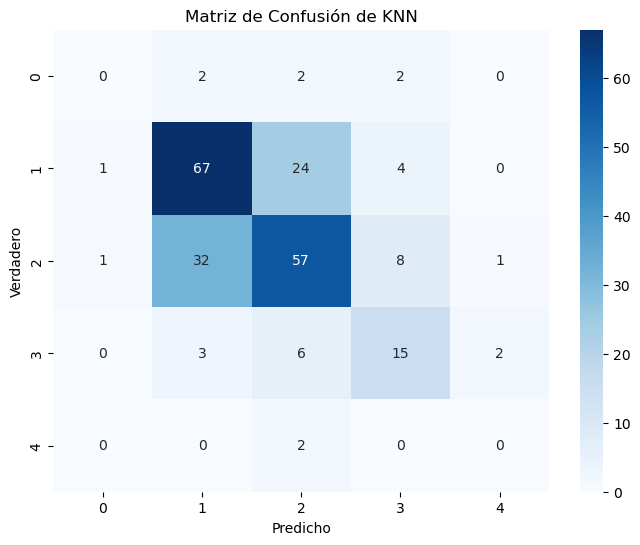

Exactitud: 0.6681222707423581
Informe de Clasificación RFC:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.70      0.76      0.73        96
           6       0.65      0.64      0.64        99
           7       0.65      0.65      0.65        26
           8       0.00      0.00      0.00         2

    accuracy                           0.67       229
   macro avg       0.40      0.41      0.40       229
weighted avg       0.65      0.67      0.66       229

Matriz de Confusión RFC:
[[ 0  3  3  0  0]
 [ 1 73 21  1  0]
 [ 0 29 63  7  0]
 [ 0  0  9 17  0]
 [ 0  0  1  1  0]]


c:\Users\diego\miniconda3\envs\bootcamp_mitic_ds\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\miniconda3\envs\bootcamp_mitic_ds\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\miniconda3\envs\bootcamp_mitic_ds\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

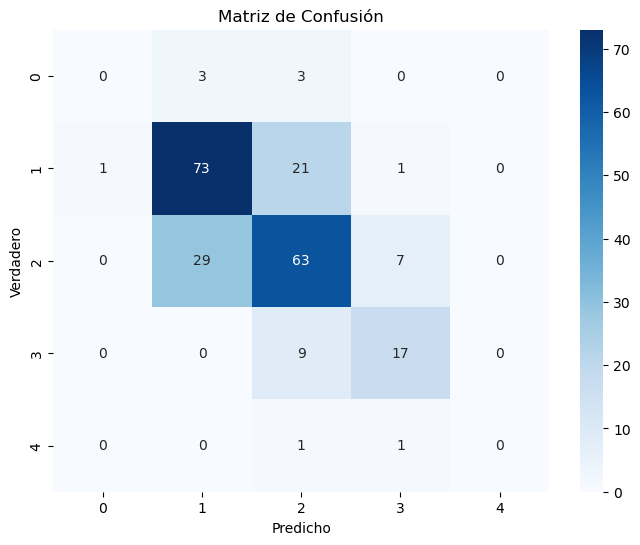

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

# Evaluar el modelo knn
accuracy = accuracy_score(y_test, y_pred_k)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación knn:')
print(classification_report(y_test, y_pred_k))

# Matriz de Confusión knn
conf_matrix_k = confusion_matrix(y_test, y_pred_k)
print('Matriz de Confusión:')

# Plotear la matriz de confusión knn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_k, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión de KNN')
plt.show()

# Evaluar el modelo rfc
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación RFC:')
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print('Matriz de Confusión RFC:')
print(conf_matrix_rf)


# Plotear la matriz de confusión rfc
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()




 5. Análisis y Comparación de Resultados:

- Comparar el rendimiento de los diferentes modelos.
- Discutir cuál modelo ofrece el mejor rendimiento y por qué.
- Identificar las fortalezas y debilidades de cada enfoque en este contexto.


### Comparación de Rendimiento entre KNN y RandomForestClassifier:

1. **Exactitud:**

- KNN: 0.607

- Random Forest: 0.668

La exactitud general del Random Forest es superior a la del KNN. Esto indica que, en promedio, el Random Forest clasifica correctamente más instancias que el KNN.

### Discusión del Mejor Modelo:

- **Rendimiento General:** El Random Forest ofrece una mejor exactitud general (0.668 frente a 0.607) y mejores métricas ponderadas en comparación con el KNN. Esto sugiere que, en promedio, Random Forest es más efectivo para este conjunto de datos.

- **Precision y Recall:** Random Forest tiene valores de precisión y recall más consistentes y altos para las clases principales (5, 6, 7) en comparación con KNN. Esto es importante porque en problemas de clasificación, estos valores ayudan a entender cuántas instancias positivas se predicen correctamente y la proporción de verdaderos positivos entre las predicciones positivas.

